# Volume 3: GMM
    Daniel Perkins
    MATH 407
    1/19/25

In [1]:
import numpy as np
from scipy import stats as st
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
import time

from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# Problems 1-7

As described in the pdf, write the functions for initialization, calculating the logpdf both for a component and the entire GMM, drawing a sample from the GMM, performing the E and M step of the EM algorithm respectively, Using the previous methods to write a fit method for training and a predict method for clustering.

In [39]:
class GMM:
    # Problem 1
    def __init__(self, n_components, weights=None, means=None, covars=None):
        """
        Initializes a GMM.
        
        The parameters weights, means, and covars are optional. If fit() is called,
        they will be automatically initialized from the data.
        
        If specified, the parameters should have the following shapes, where d is
        the dimension of the GMM:
            weights: (n_components,)
            means: (n_components, d)
            covars: (n_components, d, d)
        """
        # Store the parameters
        self.n_components = n_components   # K
        self.weights = weights  # (K, )
        self.means = means  # (K, d)
        self.covars = covars  # (K, d, d)
    
    # Problem 2
    def component_logpdf(self, k, z):
        """
        Returns the logarithm of the component pdf. This is used in several computations
        in other functions.
        
        Parameters:
            k (int) - the index of the component
            z ((d,) or (..., d) ndarray) - the point or points at which to compute the pdf
        Returns:
            (float or ndarray) - the value of the log pdf of the component at 
        """
        # Extract data
        w = self.weights[k]
        mu = self.means[k]
        sigma = self.covars[k]
        
        return np.log(w) + st.multivariate_normal.logpdf(z, mean=mu, cov=sigma)
    
    # Problem 2
    def pdf(self, z):
        """
        Returns the probability density of the GMM at the given point or points.
        
        Parameters:
            z ((d,) or (..., d) ndarray) - the point or points at which to compute the pdf
        Returns:
            (float or ndarray) - the value of the GMM pdf at z
        """
        sum = 0
        for k in range(self.n_components):
            pdf = np.exp(self.component_logpdf(k, z))  # Compute pdf
            sum += pdf
        return sum
            
    
    # Problem 3
    def draw(self, n):
        """
        Draws n points from the GMM.
        
        Parameters:
            n (int) - the number of points to draw
        Returns:
            ((n,d) ndarray) - the drawn points, where d is the dimension of the GMM.
        """
        sample = np.empty((n, len(self.means[0])))
        
        # Sample X from categorical distribution
        X = np.random.choice(len(self.weights), size=n, p=self.weights)
        
        for i, x in enumerate(X):  # Draw Z
            Z = st.multivariate_normal.rvs(mean=self.means[x], cov=self.covars[x])
            sample[i] = Z
            
        return sample

    
    # Problem 4
    def _compute_e_step(self, Z):
        """
        Computes the values of q_i^t(k) for the given data and current parameters.
        
        Parameters:
            Z ((n, d) ndarray): the data that is being used for training; d is the
                    dimension of the data.
        Returns:
            ((n_components, n) ndarray): an array of the computed q_i^t(k) values, such
                    that result[k,i] = q_i^t(k).
        """        
        # Compute the log probabilities
        log_probs = np.array([self.component_logpdf(k, Z) for k in range(self.n_components)]) 
        
        # Compute L
        L = np.max(log_probs, axis=0)
        
        # Compute q
        numerator = np.exp(log_probs - L)
        denominator = np.sum(numerator, axis=0)
        q = numerator / denominator
        
        return q
        
        
    # Problem 5
    def _compute_m_step(self, Z):
        """
        Takes a step of the expectation maximization (EM) algorithm. Return
        the updated parameters.
        
        Parameters:
            Z (n,d) ndarray): the data that is being used for training; d is the
                    dimension of the data.
        Returns:
            ((n_components,) ndarray): the updated component weights
            ((n_components,d) ndarray): the updated component means
            ((n_components,d,d) ndarray): the updated component covariance matrices
        """        
        # Shape: (K,n)
        q_values = self._compute_e_step(Z)
        
        # New weights
        new_w = np.mean(q_values, axis=1)
        
        # Compute the new means
        new_means = np.empty((self.n_components, len(Z[0])))
        for k in range(self.n_components):   # Add new axis to q to allow for array broadcasting
            new_means[k] = np.sum(q_values[k][:, np.newaxis] * Z, axis=0) / np.sum(q_values[k])
        
        # Compute the new covariances
        obs_centered = np.expand_dims(Z, 0) - np.expand_dims(new_means, 1)
        new_covars = np.einsum('Kn,Knd,KnD->KdD', q_values, obs_centered, obs_centered) / np.sum(q_values, axis=1).reshape(-1, 1, 1)
        
        return new_w, new_means, new_covars
        
    # Problem 6
    def fit(self, Z, tol=1e-3, maxiter=200):
        """
        Fits the model by applying the Expectation Maximization algorithm until the
        parameters appear to converge.
        
        Parameters:
            Z ((n,d) ndarray): the data to use for training; d is the
                dimension of the data.
            tol (float): the tolderance to check for convergence
            maxiter (int): the maximum number of iterations allowed
        Returns:
            self
        """
        # Initialize things if the don't already exist
        n, d = np.shape(Z)
        if self.weights is None: self.weights = (1/self.n_components)*np.ones(self.n_components)  # Start with equal probability
        # Randomly choose points as initial means
        if self.means is None: self.means = Z[np.random.choice(n, self.n_components, replace=False)]
        # Initialize covariance based on the variance of the data
        if self.covars is None: self.covars = np.array([np.diag(np.var(Z, axis=0)) for i in range(self.n_components)])
        
        old_weights, old_means, old_covars = self.weights, self.means, self.covars
        
        for iteration in range(maxiter):
            
            new_weights, new_means, new_covars = self._compute_m_step(Z) # E and M Step
            self.weights, self.means, self.covars = new_weights, new_means, new_covars
            
            # See if it converged
            change = (np.max(np.abs(new_weights - old_weights))  
                + np.max(np.abs(new_means - old_means))
                + np.max(np.abs(new_covars - old_covars)))
            
            if change < tol: break
            
            old_weights, old_means, old_covars = new_weights, new_means, new_covars

        # Store the attributes and return self
        return self
            
    # Problem 7
    def predict(self, Z):
        """
        Predicts the labels of data points using the trained component parameters.
        
        Parameters:
            Z ((m,d) ndarray): the data to label; d is the dimension of the data.
        Returns:
            ((m,) ndarray): the predicted labels of the data
        """
        probs = [[self.component_logpdf(k, z) for k in range(self.n_components)] for z in Z]  # Compute probabilities
        labels = [np.argmax(prob) for prob in probs]  # Calculate the labels (see equation above prob 7)
        return labels
        
    def fit_predict(self, Z, tol=1e-3, maxiter=200):
        """
        Fits the model and predicts cluster labels.
        
        Parameters:
            Z ((m,d) ndarray): the data to use for training; d is the
                dimension of the data.
            tol (float): the tolderance to check for convergence
            maxiter (int): the maximum number of iterations allowed
        Returns:
            ((m,) ndarray): the predicted labels of the data
        """
        return self.fit(Z, tol, maxiter).predict(Z)

# Check Section

In [3]:
# this is used for the majority of the tests and is provided for your convenience.
def init_gmm():
    gmm = GMM(n_components=2,
        weights=np.array([0.6, 0.4]),
        means=np.array([[-0.5, -4.0], [0.5, 0.5]]),
        covars=np.array([
        [[1, 0], [0, 1]],
        [[0.25, -1], [-1, 8]],
        ]))
    
    return gmm

### Check for Problem2 
An example of writing a check function. Alternatively an np.allclose can be used as long as
it is obvious that they are comparing the correct things.

In [10]:
def check_problem2():
    gmm = init_gmm()
    
    print(f"For input [1,-3.5] the pdf output should be: 0.0577912539363083.\n\tMine gives {gmm.pdf(np.array([1.0, -3.5]))}")
    print(f"For input [1,-3.5] the log_component output for k = 0 should be: -3.598702690175336.\n\tMine gives {gmm.component_logpdf(0, np.array([1.0, -3.5]))}")
    print(f"For input [1,-3.5] the log_component output for k = 1 should be: -3.7541677982835004.\n\tMine gives {gmm.component_logpdf(1, np.array([1.0, -3.5]))}")

check_problem2()

For input [1,-3.5] the pdf output should be: 0.0577912539363083.
	Mine gives 0.05077912539363083
For input [1,-3.5] the log_component output for k = 0 should be: -3.598702690175336.
	Mine gives -3.598702690175336
For input [1,-3.5] the log_component output for k = 1 should be: -3.7541677982835004.
	Mine gives -3.7541677982835004


### Check for problem 3 
Your results should look "good"

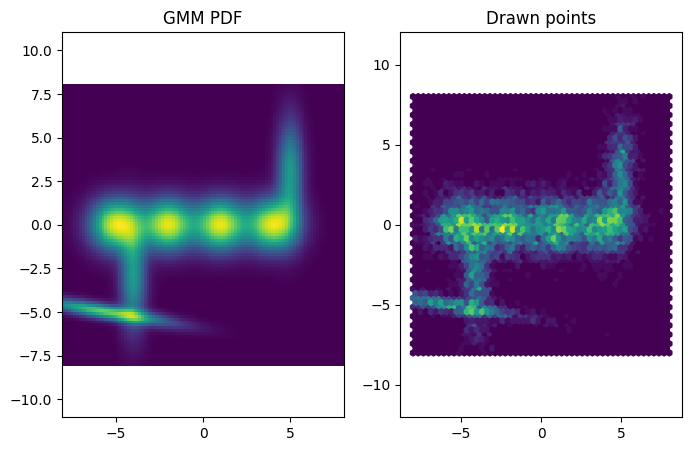

In [11]:
def check_problem3():
    """
    Draw a sample of 10,000 points from the GMM defined in the lab pdf. Plot a heatmap
    of the pdf of the GMM (using plt.pcolormesh) and a hexbin plot of the drawn points.
    How do the plots compare?
    """
    # Define the GMM
    gmm = GMM(n_components=7,
        weights=np.array([0.175, 0.175, 0.175, .175, .1, .1, .1]),
        means=np.array([[-5, 0], [-2, 0], [1, 0], [4, 0], [-4, -3], [5, 3], [-5.5, -5]]),   # [-4,-2],[-5,-5]
        covars=np.array([
            [[1, 0], [0, 1]],
            [[1, 0], [0, 1]],
            [[1, 0], [0, 1]],
            [[1, 0], [0, 1]],
            [[0.25, 0], [0, 4]],
            [[0.25, 0], [0, 4]],
            [[6, -1], [-1, .25]]# [[2, -20],[0, .25]]#[[0.25, -1],[-1, 8]],[[.25,-2],[-1,2]]
        ]))
        
    points = gmm.draw(10_000)
    
    plt.figure(figsize=(8, 5))
    # PDF
    x = np.linspace(-8, 8, 100)
    y = np.linspace(-8, 8, 100)
    X, Y = np.meshgrid(x, y)
    Z = gmm.pdf(np.dstack((X, Y)))
    
    plt.subplot(1, 2, 1)
    plt.pcolormesh(X, Y, Z)
    plt.axis('equal')
    plt.title("GMM PDF")
    
    # Hexbin
    plt.subplot(1, 2, 2)
    plt.hexbin(points[:, 0], points[:, 1], extent=(-8, 8, -8, 8), gridsize=50)
    plt.axis('equal')
    plt.title("Drawn points")
    
    plt.show()
    
check_problem3()

### Check for problem 4

In [34]:
def check_problem4():
    gmm = init_gmm()

    data = np.array([
        [0.5, 1.0],
        [1.0, 0.5],
        [-2.0, 0.7]
        ])
    
    correct = np.array([[3.49810771e-06, 5.30334386e-05, 9.99997070e-01],
                    [9.99996502e-01, 9.99946967e-01, 2.93011749e-06]])
    # WRITE YOUR TESTS HERE
    output = gmm._compute_e_step(data)
    print(f"For input \n{data}\n, the output should be \n{correct}\n")
    print(f"Mine gives \n{output}\n")
    
    if np.max(output - correct < 0.01):
        print("The output is correct")
    else:
        print("The output is incorrect")
    
check_problem4()

For input 
[[ 0.5  1. ]
 [ 1.   0.5]
 [-2.   0.7]]
, the output should be 
[[3.49810771e-06 5.30334386e-05 9.99997070e-01]
 [9.99996502e-01 9.99946967e-01 2.93011749e-06]]

Mine gives 
[[3.49810771e-06 5.30334386e-05 9.99997070e-01]
 [9.99996502e-01 9.99946967e-01 2.93011749e-06]]

The output is correct


### Check for problem 5

In [20]:
def check_problem5():
    gmm = init_gmm()

    data = np.array([
        [0.5, 1.0],
        [1.0, 0.5],
        [-2.0, 0.7]
        ])
    
    cor_w, cor_mus, cor_sigs = (np.array([0.3333512, 0.6666488]),
                            np.array([[-1.99983216, 0.69999044], [0.74998978, 0.75000612]]),
                            np.array([[[4.99109197e-04, -2.91933135e-05], 
                                        [-2.91933135e-05, 2.43594533e-06]],
                                        [[6.25109881e-02, -6.24997069e-02], 
                                        [-6.24997069e-02, 6.24999121e-02]]]))
    # WRITE YOUR TESTS HERE
    w, mus, sigs = gmm._compute_m_step(data)
    
    print(f"For the input \n{data}\nThe output should be:")
    print("w:", cor_w)
    print("mu:", cor_mus)
    print("sig:", cor_sigs)
    print()
    print(f"Mine gives")
    print("w:", w)
    print("mu:", mus)
    print("sig:", sigs)
    print()
    
    if np.max(cor_w - w < 0.01) and np.max(cor_mus - mus < 0.01) and np.max(cor_sigs - sigs < 0.01):
        print("The output is correct")
    else:
        print("The output is incorrect")
        
    
check_problem5()

For the input 
[[ 0.5  1. ]
 [ 1.   0.5]
 [-2.   0.7]]
The output should be:
w: [0.3333512 0.6666488]
mu: [[-1.99983216  0.69999044]
 [ 0.74998978  0.75000612]]
sig: [[[ 4.99109197e-04 -2.91933135e-05]
  [-2.91933135e-05  2.43594533e-06]]

 [[ 6.25109881e-02 -6.24997069e-02]
  [-6.24997069e-02  6.24999121e-02]]]

Mine gives
w: [0.3333512 0.6666488]
mu: [[-1.99983216  0.69999044]
 [ 0.74998978  0.75000612]]
sig: [[[ 4.99109197e-04 -2.91933135e-05]
  [-2.91933135e-05  2.43594533e-06]]

 [[ 6.25109881e-02 -6.24997069e-02]
  [-6.24997069e-02  6.24999121e-02]]]

The output is correct


### Check for problem 6
Initialize a GMM object in the indicated position and fit the data loaded from the .npy file, then run the cell to see a beloved Disney character

Time to train: 0.13838814799999


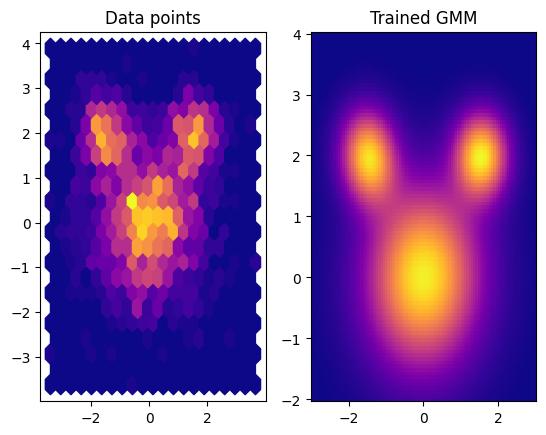

In [23]:
def check_problem6(filename='gmm_data.npy'):
    """
    The file problem6.npy contains a collection of data drawn from a GMM.
    Train a GMM on this data with n_components=3. Plot the pdf of your
    trained GMM, as well as a hexbin plot of the data.
    """
    data = np.load(filename)
    
    start = time.perf_counter()
    ################################# YOU WRITE CODE HERE ##########################################
    # Train the GMM !Call the variable gmm so this rest of the code works!
    
    #gmm = intialize with 3 components and fit 'data'
    gmm = GMM(3)
    gmm.fit(data)
    
    ################################################################################################
    end = time.perf_counter()

    # Plot the pdf and a hexbin
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-2, 4, 100)
    X, Y = np.meshgrid(x, y)
    XY = np.dstack((X, Y))
    
    # Plot the data points
    plt.subplot(1, 2, 1)
    plt.hexbin(data[:, 0], data[:, 1], gridsize=20, cmap='plasma')
    plt.title("Data points")
    
    plt.subplot(1, 2, 2)
    plt.pcolormesh(X, Y, gmm.pdf(XY), shading='auto', cmap='plasma')
    plt.title("Trained GMM")
    
    print(f"Time to train: {end-start}")
    plt.show()
    
check_problem6()

# Problem 7

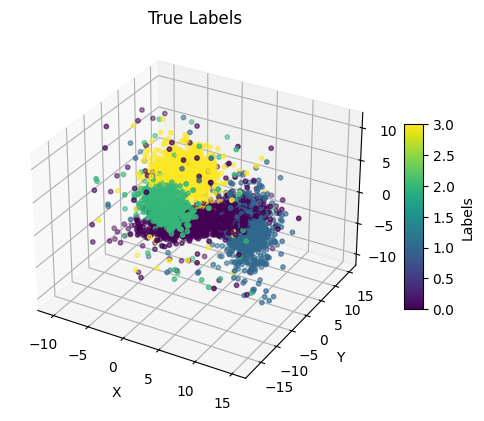

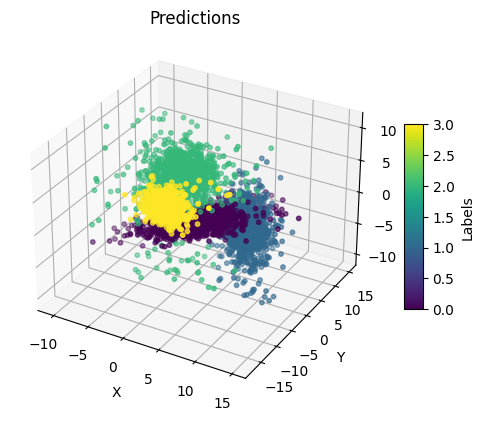

Clustering Accuracy: 0.8806


In [54]:
def get_accuracy(pred_y, true_y):
    """
    Helper function to calculate the actually clustering accuracy, accounting for
    the possibility that labels are permuted.
    
    This computes the confusion matrix and uses scipy's implementation of the Hungarian
    Algorithm (linear_sum_assignment) to find the best combination, which is generally
    much faster than directly checking the permutations.
    """
    # Compute confusion matrix
    cm = confusion_matrix(pred_y, true_y)
    # Find the arrangement that maximizes the score
    r_ind, c_ind = linear_sum_assignment(cm, maximize=True)
    return np.sum(cm[r_ind, c_ind]) / np.sum(cm)
    
def problem7(filename='classification.npz'):
    """
    The file classification.npz contains a set of 3-dimensional data points "X" and 
    their labels "y". Use your class with n_components=4 to cluster the data.
    Plot the points with the predicted and actual labels, and compute and return
    your model's accuracy. Be sure to check for permuted labels.
    
    Returns:
        (float) - the GMM's accuracy on the dataset
    """
    # Load in the data
    data = np.load(filename)
    X, true_y = data['X'], data['y']
    
    # Train the model
    gmm = GMM(4)
    pred_y = gmm.fit_predict(X)
    
    # Plot it
    x_coords, y_coords, z_coords = X[:, 0], X[:, 1], X[:, 2]
    
    # Acutual Labels Plot
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    scatter = ax.scatter(x_coords, y_coords, z_coords, c=true_y, cmap='viridis', s=10, marker='o')
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Labels')
    ax.set_title("True Labels")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
    # Predictions Plot
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    scatter = ax.scatter(x_coords, y_coords, z_coords, c=pred_y, cmap='viridis', s=10, marker='o')
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Labels')
    ax.set_title("Predictions")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
    # Get the accuracy
    return get_accuracy(pred_y, true_y)
    
acc = problem7()
print("Clustering Accuracy:", acc)

In [47]:
def method_comparison(filename='classification.npz'):
    """
    Again using classification.npz, compare your class, sklearn's GMM implementation, 
    and sklearn's K-means implementation for speed of training and for accuracy of 
    the resulting clusters. Print your results. Be sure to check for permuted labels.
    """
    # Load the data
    data = np.load(filename)
    X, true_y = data['X'], data['y']
    
    # Our class
    start = time.perf_counter()
    gmm = GMM(n_components=4).fit(X)
    end = time.perf_counter()
    gmm_pred = gmm.predict(X)
    gmm_time = end - start
    gmm_acc = get_accuracy(true_y, gmm_pred)
    
    # sklearn GMM
    start = time.perf_counter()
    sk_gmm = GaussianMixture(n_components=4).fit(X)
    end = time.perf_counter()
    sk_gmm_pred = sk_gmm.predict(X)
    sk_gmm_time = end - start
    sk_gmm_acc = get_accuracy(true_y, sk_gmm_pred)
    
    # sklearn K-means
    start = time.perf_counter()
    sk_km = KMeans(n_clusters=4).fit(X)
    end = time.perf_counter()
    sk_km_pred = sk_km.predict(X)
    sk_km_time = end - start
    sk_km_acc = get_accuracy(true_y, sk_km_pred)
    
    print("Our GMM class:")
    print(f"\tAccuracy: {gmm_acc:.4f}")
    print(f"\tTrain time: {gmm_time:.6f} s")
    
    print("sklearn GMM:")
    print(f"\tAccuracy: {sk_gmm_acc:.4f}")
    print(f"\tTrain time: {sk_gmm_time:.6f} s")
    
    print("sklearn K-means:")
    print(f"\tAccuracy: {sk_km_acc:.4f}")
    print(f"\tTrain time: {sk_km_time:.6f} s")
    
method_comparison()

/home/dbp52/.acme-venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Our GMM class:
	Accuracy: 0.5854
	Train time: 0.729603 s
sklearn GMM:
	Accuracy: 0.8924
	Train time: 0.175206 s
sklearn K-means:
	Accuracy: 0.7552
	Train time: 1.589345 s


# Problem 8

K-means was a poor predictor as compared to the GMM for the clustering of are data points. This is because, as the pdf explains, K-means is practically a simplified version of a GMM. It determines clusters by measuring the Euclidean distance between points. This is essentially a GMM with identity matrices as the variance. The GMM we used, on the other hand, also learns the variances. This gives it the ability to learn more complicated (nonlinear) distributions to represent the data, increasing the chances of a higher accuracy.